In [101]:
import pandas as pd 
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report , accuracy_score
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

In [103]:
# OBSERVANDO OVERFITTING
def curva_aprendizado(model):
    train_sizes, train_scores, val_scores = learning_curve(model, x_train, y_train, cv=5)


    train_scores_mean = train_scores.mean(axis=1)
    val_scores_mean = val_scores.mean(axis=1)

    plt.plot(train_sizes, train_scores_mean, label="Treino")
    plt.plot(train_sizes, val_scores_mean, label="Validação")
    plt.legend()
    plt.title("Curva de Aprendizado")
    plt.show()

In [146]:
conexao = sqlite3.connect(r'instance/pulsefit.db')

script = '''
SELECT --mes_semana,
	   dias_presentes,
	   dias_desde_ultimo_checkin, 
	   duracao_media_horas, 
	   NOME_PLANO 
	   FROM (SELECT  
			C.ID,
			C.NOME,
			strftime('%m-%W', dt_checkin) AS mes_semana,
			COUNT(DISTINCT date(ch.dt_checkin)) AS dias_presentes,
			MAX(dt_checkin) AS ultimo_checkin,
			ROUND(julianday('now') - julianday(MAX(dt_checkin))) AS dias_desde_ultimo_checkin,
			ROUND(AVG((julianday(dt_checkout) - julianday(dt_checkin)) * 24), 2) AS duracao_media_horas,
			C.ID AS ID_PLANO,
			P.plano AS NOME_PLANO
		 FROM CLIENTE C, PLANO P, checkin CH WHERE C.PLANO = P.ID AND CH.CLIENTE_ID = C.ID 
		 GROUP BY C.ID, C.NOME, mes_semana)
'''

df = pd.read_sql(script, conexao)


In [147]:
print("Quantidade de dados: ", df.shape)

Quantidade de dados:  (744, 4)


In [148]:
df

dias_presentes  dias_desde_ultimo_checkin  duracao_media_horas  \
0                 3                      109.0                28.49   
1                 2                      106.0                36.18   
2                 7                       94.0                34.80   
3                 7                       87.0                27.86   
4                 5                       82.0                34.79   
..              ...                        ...                  ...   
739               7                       31.0                29.65   
740               7                       24.0                38.85   
741               1                       23.0                16.70   
742               2                       21.0                47.46   
743               4                        4.0                42.14   

       NOME_PLANO  
0     Plano Black  
1     Plano Black  
2     Plano Black  
3     Plano Black  
4     Plano Black  
..            ...  
739  Plano Básico  
740  Plano Básico  
741  Plano Básico  
742  Plano Básico  
743  Plano Básico  

[744 rows x 4 columns]

In [149]:
df['NOME_PLANO'].value_counts()

NOME_PLANO
Plano Básico    316
Plano Fit       217
Plano Black     211
Name: count, dtype: int64

## 1 - TRATANDO DADOS

### 1.1 - Definindo cancelamento para clientes com dias desde o ultimo checkin como maior de 30 e dias presente menor que 4

In [150]:
df['cancelou'] = df.apply(
    lambda row: 1 if row['dias_desde_ultimo_checkin'] > 30 and row['dias_presentes'] < 4 else 0, 
    axis=1
)

In [151]:
df['cancelou'].value_counts()

cancelou
0    510
1    234
Name: count, dtype: int64

### 1.2 - TRANSFORMANDO VALORES CATEGORICOS EM NUMERICOS 

In [152]:
labelEncoder = LabelEncoder()
df['NOME_PLANO'] = labelEncoder.fit_transform(df['NOME_PLANO'])

## 2 - DIVISÃO DOS DADOS

In [153]:
x = df[['dias_presentes', 'dias_desde_ultimo_checkin', 'duracao_media_horas', 'NOME_PLANO']]
y = df['cancelou']

In [154]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

3 - TREINANDO MODELOS

In [155]:
logistic_model = LogisticRegression()

rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier()

logistic_model.fit(x_train, y_train)
rf_model.fit(x_train, y_train)
xgb_model.fit(x_train, y_train)

rf_preds = rf_model.predict(x_test)
xgb_preds = xgb_model.predict(x_test)
logistic_pred = logistic_model.predict(x_test)

#### 3.1 - AVALIANDO MODELOS

In [156]:

print('Regressão Logistica\n', classification_report(y_test, logistic_pred))
print('Arvore Randomica\n', classification_report(y_test, rf_preds))
print('XGB\n', classification_report(y_test, xgb_preds))

Regressão Logistica
               precision    recall  f1-score   support

           0       0.93      0.88      0.90       101
           1       0.77      0.85      0.81        48

    accuracy                           0.87       149
   macro avg       0.85      0.87      0.86       149
weighted avg       0.88      0.87      0.87       149

Arvore Randomica
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      1.00      1.00        48

    accuracy                           1.00       149
   macro avg       1.00      1.00      1.00       149
weighted avg       1.00      1.00      1.00       149

XGB
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       101
           1       1.00      1.00      1.00        48

    accuracy                           1.00       149
   macro avg       1.00      1.00      1.00       149
weighted avg       1.00      1

In [157]:
df.loc[1].iloc[:4]

dias_presentes                 2.00
dias_desde_ultimo_checkin    106.00
duracao_media_horas           36.18
NOME_PLANO                     0.00
Name: 1, dtype: float64

In [173]:
df.loc[2].iloc[:5]

dias_presentes                7.0
dias_desde_ultimo_checkin    94.0
duracao_media_horas          34.8
NOME_PLANO                    0.0
cancelou                      0.0
Name: 2, dtype: float64

In [174]:
previsoes = logistic_model.predict_proba([df.loc[2].iloc[:4]])
previsoes

c:\Users\user\Documents\estudos\flask\entrevista de emprego\Pulse_Fit\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([[0.99826374, 0.00173626]])

#### 3.2 - AVALIANDO DESEMPENHO DOS TREINAMENTOS

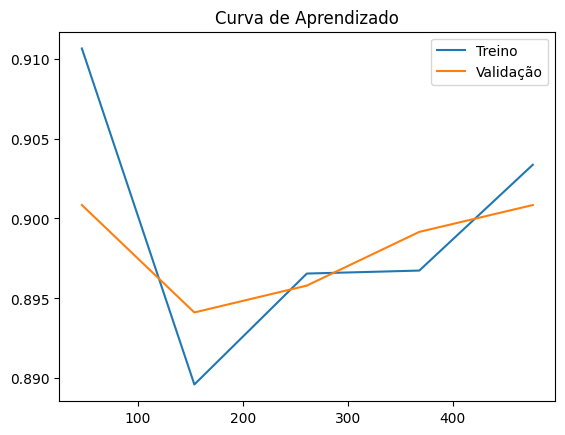

In [107]:
curva_aprendizado(logistic_model)

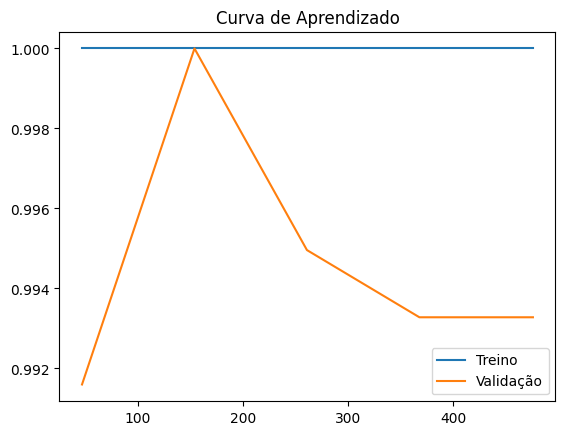

In [108]:
curva_aprendizado(rf_model)

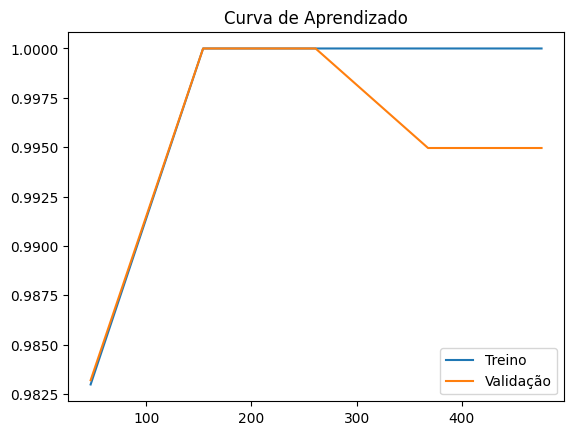

In [112]:
curva_aprendizado(xgb_model)

O modelo com melhor desempenho foi a Regressão Logística, alcançando uma acurácia geral de 87%, o que indica uma taxa elevada de acertos nas previsões sobre os dados de teste. As métricas de precisão, recall e f1-score apresentaram uma média ponderada próxima de 0.87, evidenciando um desempenho consistente e equilibrado entre as classes. Além disso, pelo gráfico de aprendizado, observa-se que as curvas de treinamento e validação estão próximas, o que sugere que o modelo está aprendendo de forma eficiente sem sinais evidentes de overfitting.